
# Porto Seguro Safe Driver Prediction



**대회 설명**

Porto Seguro는 브라질의 자동차 보험 회사

**대회 목적**
어떤 차주가 내년에 보험 청구 할 확률 예측

**데이터 특징**


1.   테스트 데이터 > 훈련 데이터
2.   결측치의 값이 -1로 주어짐
3.   각 Feature의 의미가 주어지지 않음.
4.   target = 0 : 보험 청구 no / target = 1 : 보험 청구 yes

**데이터 평가**

지니 계수를 이용하여 데이터의 성능을 평가함.

지니 계수 : 경제적 불평등을 계수화할 때 주로 사용하는 지표
* 0~0.5의 값을 가짐
* 0.5에 가까울수록 좋은 분석임.

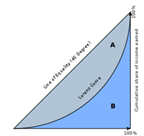

위 그림에서 A/(A+B)가 지니 계수

Actual 값이 가지고 있는 불평등 정도 / Actual-Prediction 간의 불평등 정도

**지니 계수 쓰는 이유**
* imbalanced data 이기 때문에 이들의 평가를 위한 임계값을 어떻게 정하느냐에 따라 예측값이 바뀌므로 면적으로 스코어를 매겨 이러한 문제를 해결하기 위함

필사 커널 출처 :
https://www.kaggle.com/bertcarremans/data-preparation-exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import Imputer (버전 업그레이드 이후 sklearn.impute에서 바로 SimpleImputer 입력 가능)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/data/test.csv')

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


변수 명에 
*   bin -> binary features 
*   cat -> categorical features

이 표식이 없으면 연속형 변수 or 순서형 범주


In [ ]:
train.shape

(595212, 59)

In [ ]:
train.drop_duplicates()
train.shape

(595212, 59)

In [ ]:
test.shape

(892816, 58)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

## Meta Data

데이터 관리를 위해서 feature들의 특징을 담은 meta data 생성

**Meta Data 작성 시 장점**

어떤 조건을 가진 feature만 사용하고 싶을 때 Meta Data를 생성해 놓으면 간단한 코드로 원하는 feature를 가져올 수 있음.

In [ ]:
data= []
for f in train.columns :
  if f == 'target' :
    role = 'target'
  elif f == 'id' :
    role = 'id'
  else :
    role = 'input'

  if 'bin' in f or f == 'target' :
    level = 'binary'
  elif 'cat' in f or f == 'id' :
    level = 'nominal'
  elif train[f].dtype=='float' :
    level = 'interval'
  elif train[f].dtypes == int :
    level = 'ordinal'

  keep = True
  if f == 'id' :
    keep = False
  
  dtype = train[f].dtypes

  f_dict = {
      'varname' : f,
      'role' : role,
      'level' : level,
      'keep' : keep,
      'dtype' : dtype
  }
  data.append(f_dict)

meta = pd.DataFrame(data, columns = f_dict.keys())
meta.set_index('varname',inplace=True) # column 명으로 index 설정




In [ ]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [ ]:
# meta 데이터 사용 시 데이터 추출 용이 example
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [ ]:
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [ ]:
v = meta[(meta.level == 'interval')& (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


min : -1 주목 : 결측값이 존재하는 column들



*   ps_reg_03, ps_car_12, ps_car_14
*   calc -> maximum이 모두 0.9로 비슷한 분포를 보이고 있음 cf ) car,reg 변수들은 scaling 필요



In [ ]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 불균형 데이터 조정

타겟평균 0.0365 : 굉장히 불균형 데이터
-> 해결방안


1.   oversampling target = 1
2.   undersampling target = 0

undersampling 비율

$$  {(1-\alpha)*\beta_1 \over \beta_2*\alpha}$$


In [ ]:
desired_apriori = 0.1

idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state = 37,
                            n_samples =  undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop=True)


Rate to undersample records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


## 결측치 처리

In [ ]:
vars_with_missing = []

for f in train.columns :
  missings = train[train[f] == -1][f].count()
  if missings > 0 :
    vars_with_missing.append(f)
    missings_perc = missings/train.shape[0]

    print('Variable {} has {} records ({:.2%}) with missing values'.format(f,missings,missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))


Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values




*   ps_car_03_cat, ps_car_05_cat : missing value가 변수의 상당수를 차지함 -> 변수 제거
*   ps_reg_03 : 약 18%가 결측치 -> 평균으로 대체
*   ps_car_12 & ps_car_14 : 평균으로 대체
*   ps_car_11 : 범주형 변수이므로 mode로 대체




**[Mode]**

범주형 변수에서 결측치를 가장 등장하는 값으로 대체하는 개념

In [ ]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, axis=1, inplace=True)
meta.loc[(vars_to_drop),'keep'] = False # 변수 제거에 따라 meta data 업데이트

In [ ]:
mean_imp = SimpleImputer(missing_values=-1)
mode_imp = SimpleImputer(missing_values=-1,strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel() # ravel : 1차원 배열로 펼치는 역할 
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v :
  dist_values = train[f].value_counts().shape[0]
  print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


정형 데이터에서는 중요한 카테고리 변수에 대해 groupby를 통해 얼마나 좋은 feature를 만들어내는지가 중요 포인트

## 범주형 변수 인코딩

해당 커널에서는 distinct value가 많은 ps_car_11_cat 변수들에 대해서는 mean encoding을 사용하였고, 나머지 범주형 변수들에 대해서는 더미 변수를 생성하는 one-hot encoding의 방식 사용
### Mean encoding
**목표**

카테고리 변수에 대하여 (여기서는 104개의 카테고리를 가진 ps_car_11_cat 변수에 대하여) 단순하게 0,1로 구분된 target값에 대한 의미를 가지도록 만드는 것

**Method**

카테고리 변수의 Label 값에 따라서 Traget 값의 평균을 구해 각 Label이 Target과 가지는 상관성, 영향 도출

** 단점 **

1. target값을 이용해 계산하기 때문에 overfitting의 문제가 발생할 수 있음 -> 이 커널에서는 noise를 추가하는 방식으로 이 문제를 해결

2. test 데이터와 train 데이터 간의 분포가 다른 경우 (ex. 한쪽이 불균형 데이터인 경우) 이때도 마찬가지로 overfitting의 문제 발생 가능 -> smoothing을 통해 문제 해결

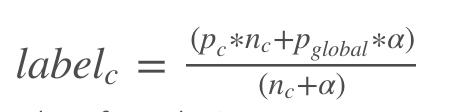


In [ ]:
trn_series = train['ps_car_11_cat']
tst_series = test['ps_car_11_cat']
target = train.target
min_samples_leaf = 100
smoothing = 10
noise_level = 0.01

In [ ]:
assert len(trn_series) == len(tst_series)

In [ ]:
assert trn_series.name == tst_series.name

In [ ]:
temp = pd.concat([trn_series,target],axis=1)

In [ ]:
average = temp.groupby(by=trn_series.name)[target.name].agg(['mean','count']) 

* temp 변수를 'ps_car_11_cat'에 대해 그룹으로 묶음.
* 각 그룹의 값은 0과 1로만 이루어져있으므로 이에 대해 mean과 count를 구함
* agg - 모든 열에 동일한 함수 적용 (열별로 다르게 적용도 가능)

In [ ]:
def max_min(x) :
  return x.max() - x.min()

In [ ]:
smoothing
1/(1+np.exp(-average['count']-min_samples_leaf) / smoothing ) # smoothing을 해야 overfitting 문제를 해결할 수 있음

ps_car_11_cat
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
Name: count, Length: 104, dtype: float64

In [ ]:
prior = target.mean()

In [ ]:
average[target.name] = prior*(1-smoothing) + average['mean']*smoothing

In [ ]:
average

,mean,count,target
ps_car_11_cat,,,
1,0.108260,1247,0.182598
2,0.103082,941,0.130818
3,0.139078,1172,0.490785
4,0.164966,588,0.749660
5,0.113000,4646,0.230004
...,...,...,...
100,0.138773,1679,0.487731
101,0.108035,2601,0.180354
102,0.097127,731,0.071272


smoothing 여부에 따라 큰 차이는 없음

In [ ]:
average.drop(['mean','count'],axis=1,inplace = True)

In [ ]:
average

,target
ps_car_11_cat,
1,0.182598
2,0.130818
3,0.490785
4,0.749660
5,0.230004
...,...
100,0.487731
101,0.180354
102,0.071272


In [ ]:
ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
         average.reset_index().rename(columns = {'index' : target.name,
                                                 target.name : 'average'}),
         on = trn_series.name, how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
# how='left' 중요!! left에 있는 모든 샘플을 살리면서 붙일 수 있음

In [ ]:
ft_trn_series.index = trn_series.index

In [ ]:
 # test 셋에서도 똑같이 수행해줌
 ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        average.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

In [ ]:
ft_tst_series = tst_series.index

In [ ]:
0.01 * np.random.randn(ft_trn_series.shape[0]) # 노이즈 설정 -> 너무 discrete 하지 않게 하려고 

array([-0.00328179,  0.00080372, -0.00380016, ...,  0.00248539,
        0.00169355, -0.0244045 ])

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target) #assert -> True면 통과, False면 에러
    assert trn_series.name == tst_series.name

    temp = pd.concat([trn_series, target], axis=1)
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    prior = target.mean()
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge - index를 보존해주지 않음
    ft_trn_series.index = trn_series.index 
   
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # 메타데이터 업데이트
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [ ]:
train_encoded

0         0.094783
1         0.122180
2         0.096908
3         0.084972
4         0.107709
            ...   
216935    0.121403
216936    0.113524
216937    0.121853
216938    0.122132
216939    0.067492
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

<Figure size 432x288 with 0 Axes>

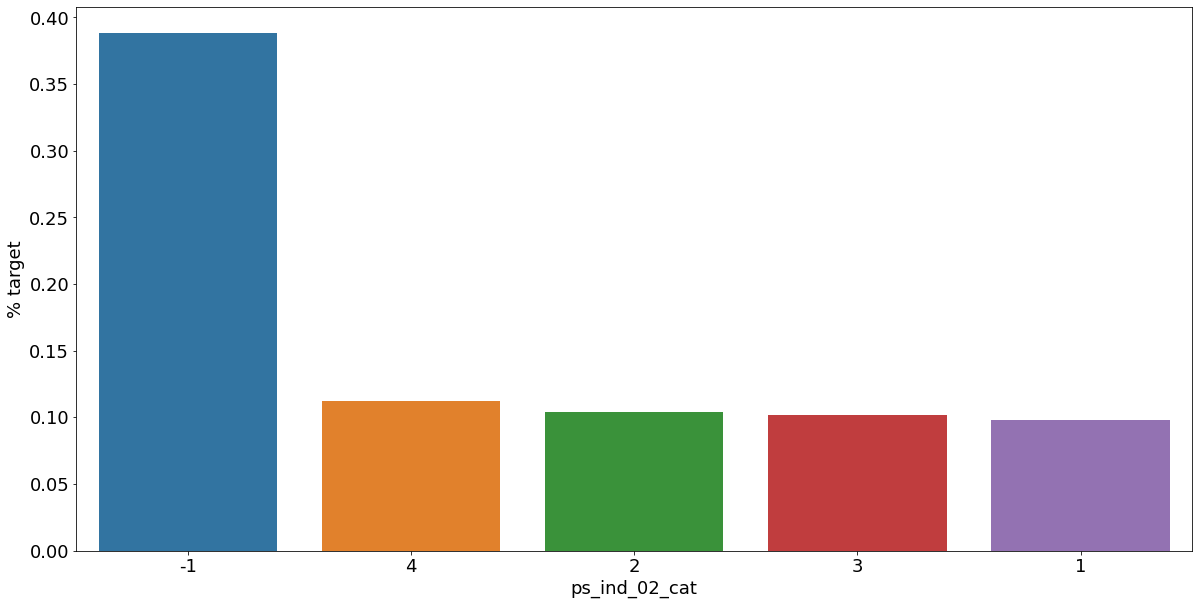

<Figure size 432x288 with 0 Axes>

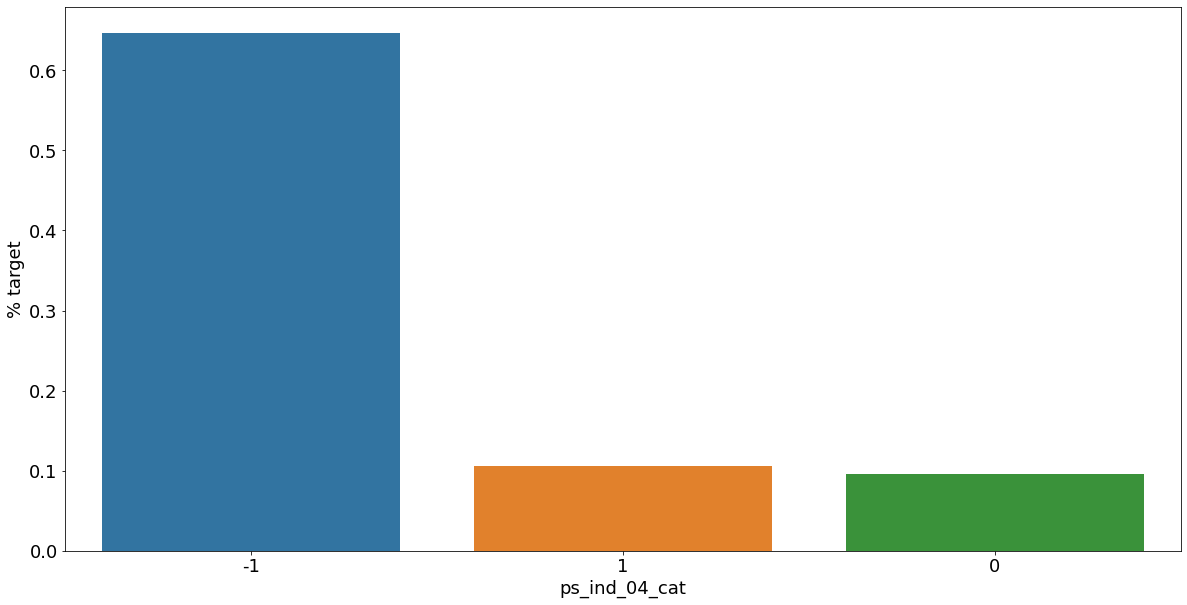

<Figure size 432x288 with 0 Axes>

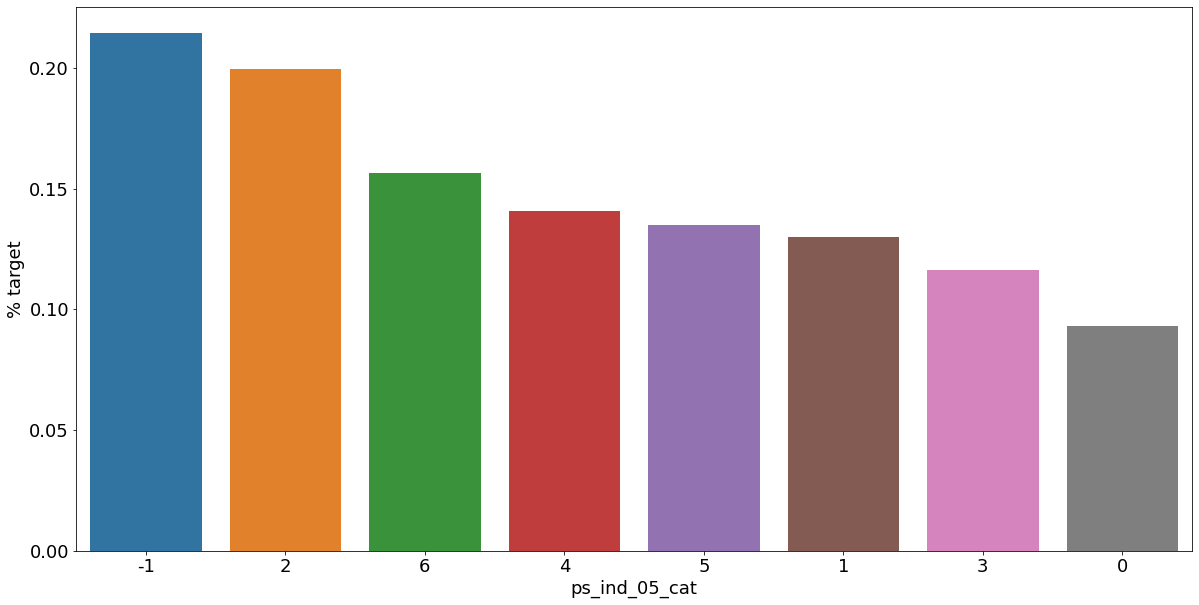

<Figure size 432x288 with 0 Axes>

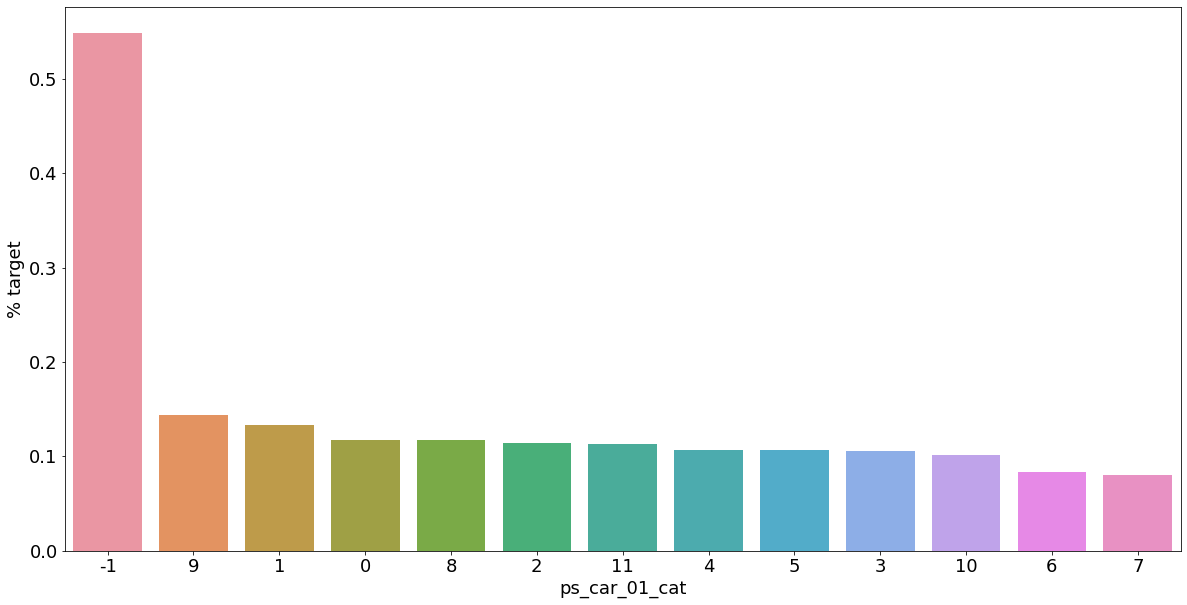

<Figure size 432x288 with 0 Axes>

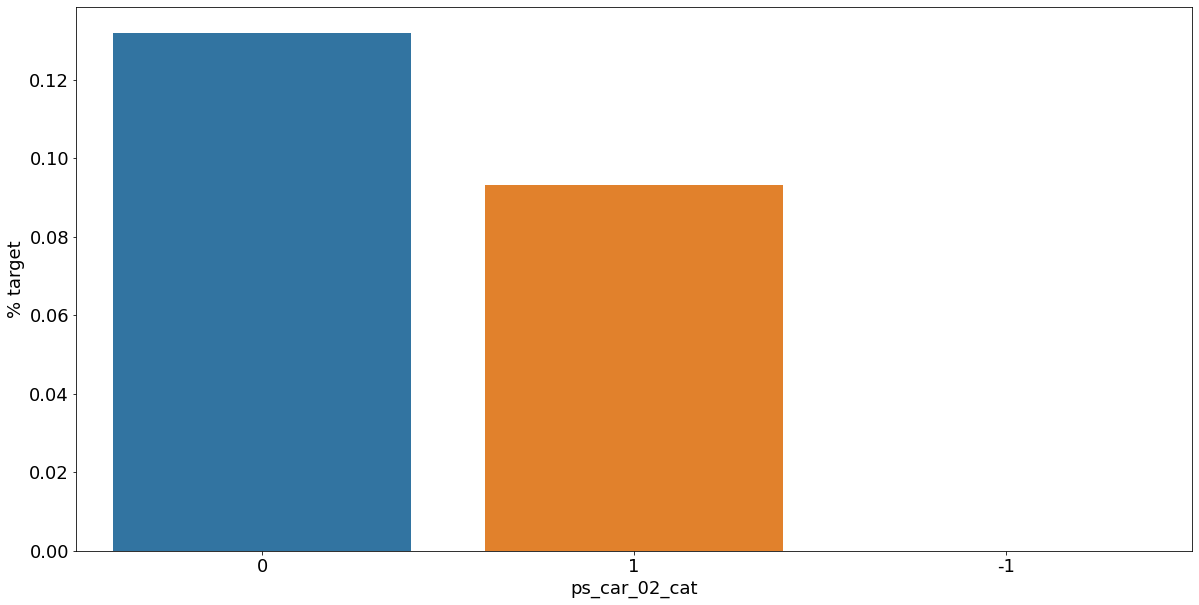

<Figure size 432x288 with 0 Axes>

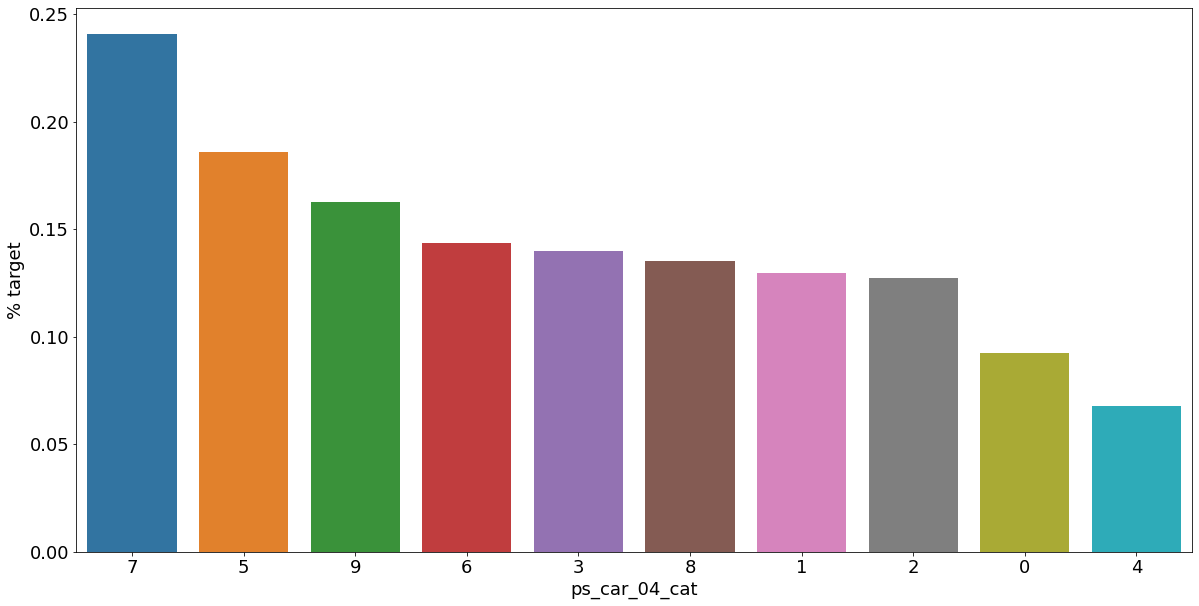

<Figure size 432x288 with 0 Axes>

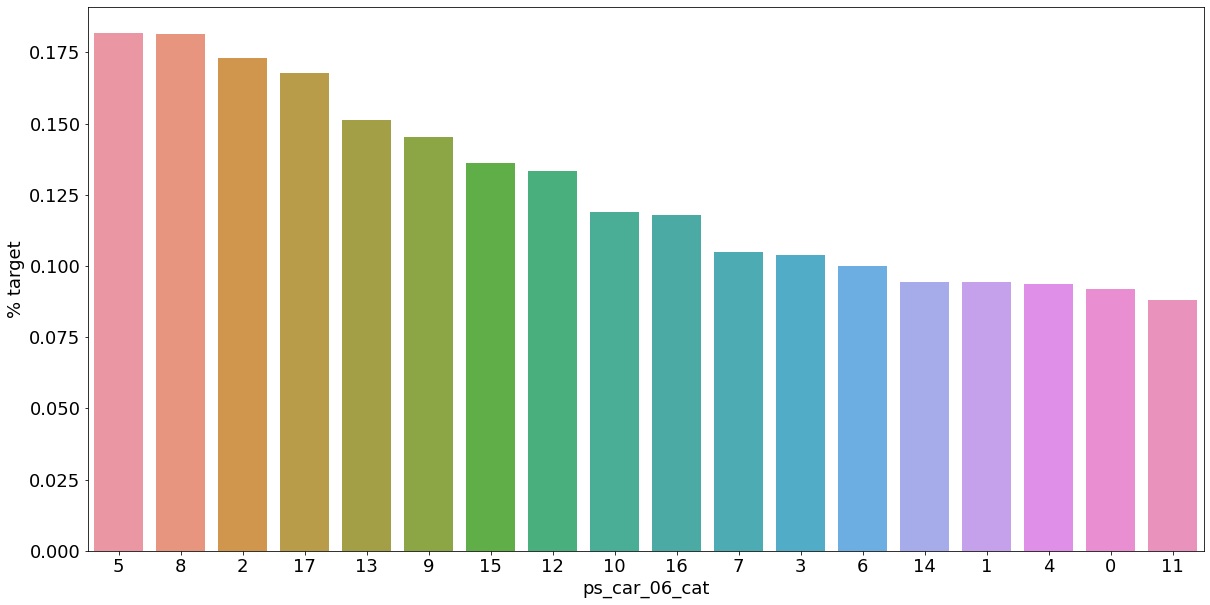

<Figure size 432x288 with 0 Axes>

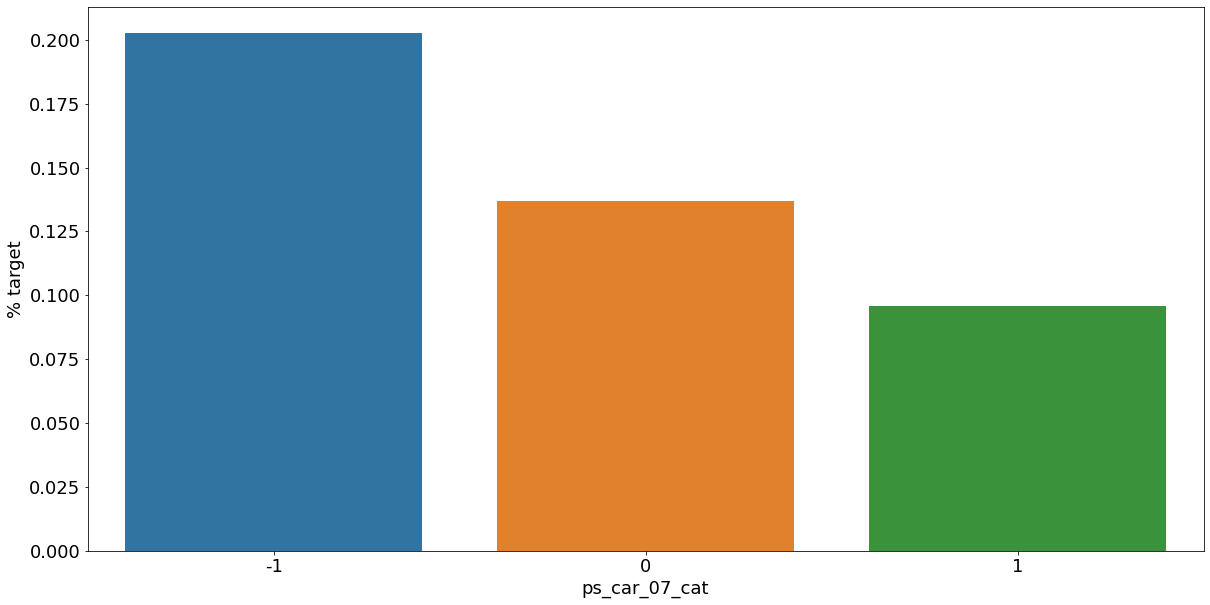

<Figure size 432x288 with 0 Axes>

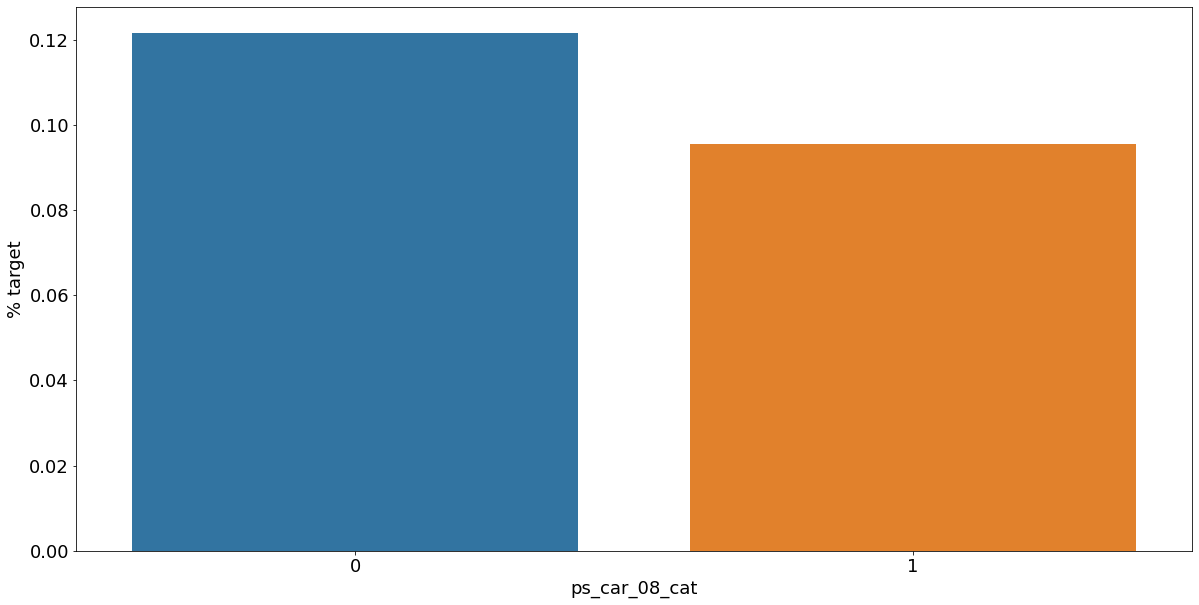

<Figure size 432x288 with 0 Axes>

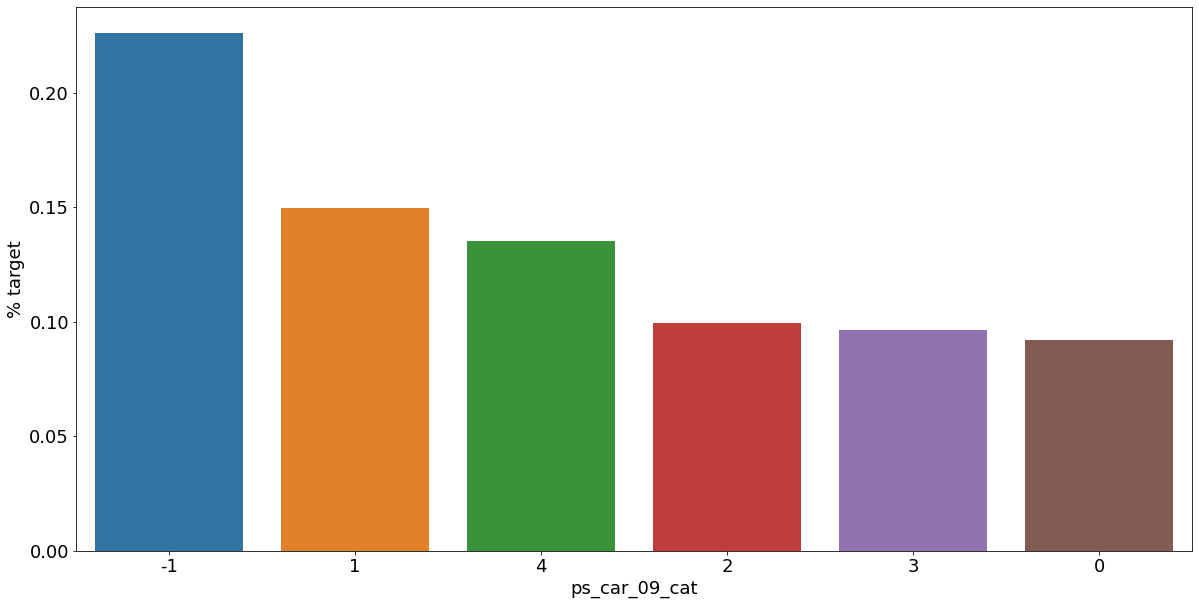

<Figure size 432x288 with 0 Axes>

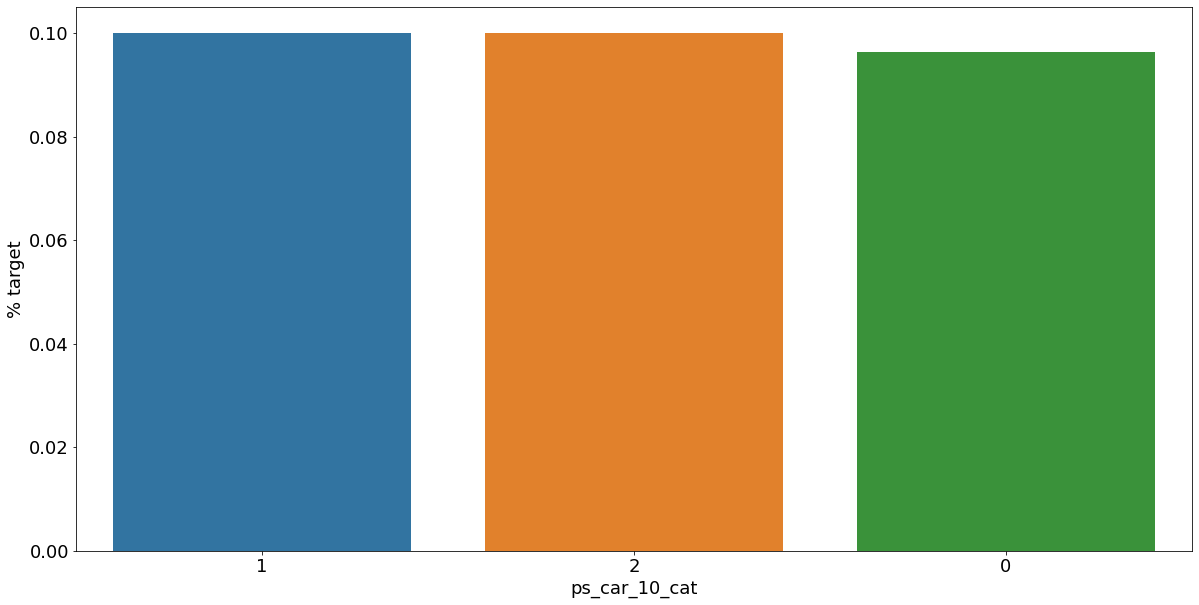

In [ ]:
v= meta[(meta.level == 'nominal')&(meta.keep)].index

for f in v:
  plt.figure()
  fig, ax = plt.subplots(figsize=(20,10))

  cat_perc = train[[f,'target']].groupby([f],as_index=False).mean()
  cat_perc.sort_values(by='target',ascending=False,inplace = True)

  sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
  plt.ylabel('% target', fontsize=18)
  plt.xlabel(f, fontsize=18)
  plt.tick_params(axis='both', which='major', labelsize=18)
  plt.show();

train 데이터에서는 결측치 처리를 해줬지만, meta data에서 각 컬럼에 대해 범주별로 target값을 비교해 보면 -1이 가장 많은 컬럼들이 많이보임. 

따라서 결측값을 가진 고객 -> 보험을 요청할 확률이 높은 것은 사실이 유의미한 것으로 판단하여 meta data를 수정하지 않음.

## 연속형 & 순서형 변수들에 대해 상관계수 그래프 그리기

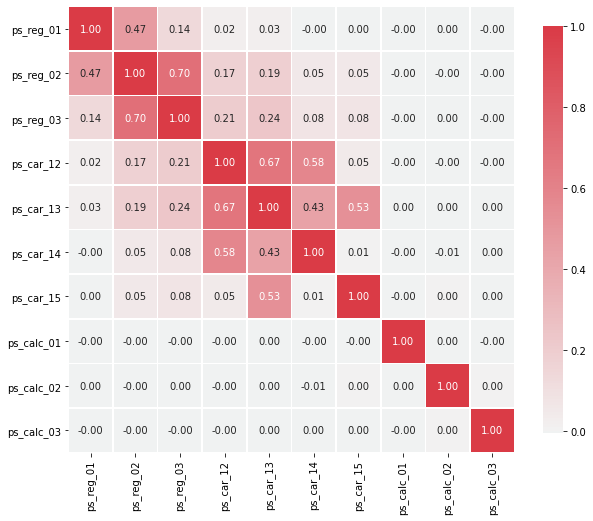

In [ ]:
def corr_heatmap(v) :
  correlations = train[v].corr()

  cmap = sns.diverging_palette(220,10,as_cmap=True)

  fig,ax = plt.subplots(figsize=(10,10))
  sns.heatmap(correlations, cmap=cmap, vmax = 1.0, center=0, fmt= '.2f',
              square = True,linewidths = .5, annot = True, cbar_kws={'shrink' : .75})
  plt.show() ;

v = meta[(meta.level== 'interval')&(meta.keep)].index
corr_heatmap(v)



*   ps_reg_02 and ps_reg_03 (0.7)
*   ps_car_12 and ps_car13 (0.67)
*   ps_car_12 and ps_car14 (0.58)
*   ps_car_13 and ps_car15 (0.67)



In [ ]:
s = train.sample(frac=0.1)

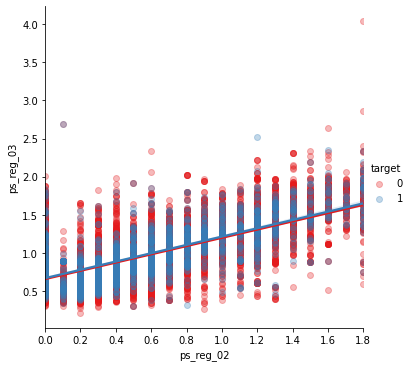

In [ ]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue= 'target',
           palette = 'Set1', scatter_kws={'alpha':0.3}) 
# scatter_kws : 그래프의 여러 옵션 딕셔너리 형태로 지정 alpha로 진함 정도, size로 기호의 크기 등 
plt.show()

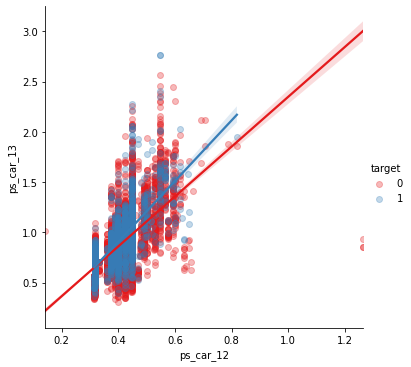

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

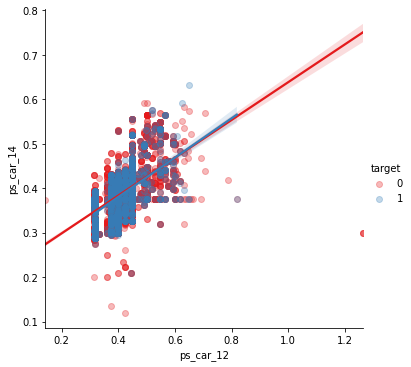

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

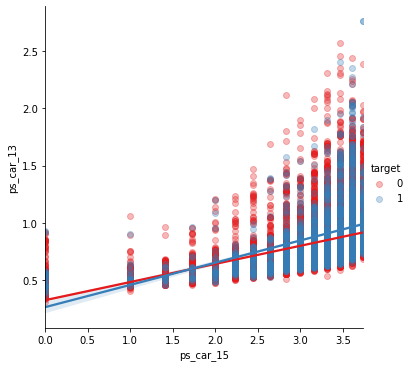

In [ ]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

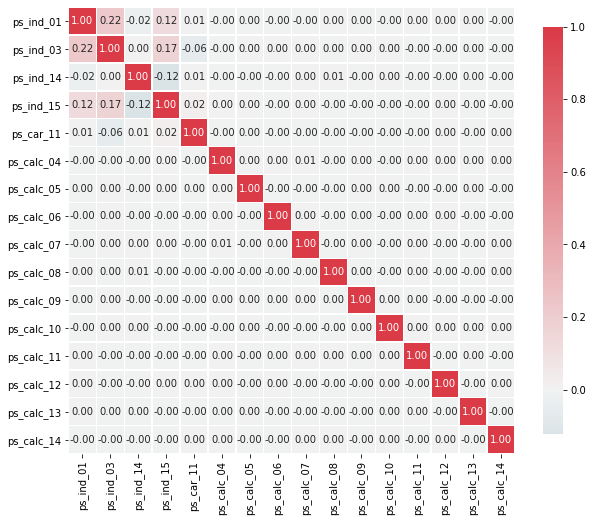

In [ ]:
v = meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

순서형 변수들 간에는 눈에 띄는 상관계수가 없음.

## Feature Engineering

변수들의 특징에 따라 변수를 새롭게 추가해주는 과정

범주형 변수들에 대하여 더미 변수 생성


In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} varibles in train'.format(train.shape[1]))
train = pd.get_dummies(train,columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 varibles in train
After dummification we have 109 variables in train


교호 작용 변수들을 생성하는 변수 생성
ex) (x1, x2, x3) to (1, x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2x3)

In [ ]:
v= meta[(meta.level=='interval')&(meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False) 
# interaction_only : 교호작용 항만 출력, include_bias : 상수항 생성 여부
interactions = pd.DataFrame(data=poly.fit_transform(train[v]),columns=poly.get_feature_names(v))
interactions.drop(v,axis=1,inplace=True)
print('Before creating interactions we have {} varibles in train'.format(train.shape[1]))
train=pd.concat([train,interactions],axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 varibles in train
After creating interactions we have 164 variables in train


In [ ]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin',
       'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin',
       'ps_ind_11_bin',
       ...
       'ps_car_15^2', 'ps_car_15 ps_calc_01', 'ps_car_15 ps_calc_02',
       'ps_car_15 ps_calc_03', 'ps_calc_01^2', 'ps_calc_01 ps_calc_02',
       'ps_calc_01 ps_calc_03', 'ps_calc_02^2', 'ps_calc_02 ps_calc_03',
       'ps_calc_03^2'],
      dtype='object', length=164)

## Feature selection

 

*   분산이 작거나 0인 경우 - 해당 변수를 제거하는 것이 좋음 (값의 변화가 다양하지 않은 경우 예측에 도움이 되지 않음)
*   VarianceThreshold 함수를 통해 variance가 낮은 값을 제거해 줄 수 있음.
*   SelectFromModel을 사용하여 사용할 변수를 선택할수도 있음. 



In [ ]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id','target'],axis=1))

f = np.vectorize(lambda x : not x)
v = train.drop(['id','target'],axis=1).columns[f(selector.get_support())] 
# selector.get_support : threshold 통과 - True, 불통 - False
# 불통인 애들만 뽑아주려고 f 함수를 통해 bool값을 뒤집어줌
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


Select From Model방식 적용

In [ ]:
X_train = train.drop(['id','target'],axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rf.fit(X_train,y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1] # 변수 중요도 내림차순 정렬

for f in range(X_train.shape[1]) :
  print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]],importances[indices[f]]))

 1) ps_car_11_cat_te               0.021239
 2) ps_car_13                      0.017366
 3) ps_car_12 ps_car_13            0.017271
 4) ps_car_13^2                    0.017270
 5) ps_car_13 ps_car_14            0.017151
 6) ps_reg_03 ps_car_13            0.017096
 7) ps_car_13 ps_car_15            0.016778
 8) ps_reg_01 ps_car_13            0.016741
 9) ps_reg_03 ps_car_14            0.016252
10) ps_reg_03 ps_car_12            0.015552
11) ps_reg_03 ps_car_15            0.015142
12) ps_car_14 ps_car_15            0.015025
13) ps_car_13 ps_calc_02           0.014723
14) ps_car_13 ps_calc_03           0.014688
15) ps_reg_01 ps_reg_03            0.014683
16) ps_car_13 ps_calc_01           0.014667
17) ps_reg_02 ps_car_13            0.014654
18) ps_reg_01 ps_car_14            0.014364
19) ps_reg_03^2                    0.014234
20) ps_reg_03                      0.014200
21) ps_reg_03 ps_calc_03           0.013797
22) ps_reg_03 ps_calc_02           0.013783
23) ps_reg_03 ps_calc_01        

In [ ]:
sfm = SelectFromModel(rf, threshold = 'median', prefit=True)
print('Number of features before selection : {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection : {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection : 162
Number of features after selection : 81


In [ ]:
train = train[selected_vars + ['target']]

## Feature Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'],axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])